In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Use logarithmic scales?
LOGY=True

# Select countries
selcnt = []
selcnt += ['Poland']
#selcnt += ['China', 'Korea, South']
selcnt += ['United Kingdom', 'US']
selcnt += ['Sweden','Germany','Norway']
selcnt += ['Italy', 'Spain']
#selcnt = ['Poland', 'Slovakia', 'Germany', 'Czechia', 'Ukraine', 'Belarus', 'Russia']
#selcnt = ['Poland', 'Germany','Sweden','US','Norway','Italy','Spain']
#selcnt = ['US', 'Germany', 'Italy', 'Spain', 'Korea, South']
#selcnt = ['Poland', 'Sweden', 'US', 'Norway']

In [3]:
# Prepare the data

def fix_names(c):
    '''
    Fix differences in naming in population and covid datasets
    '''
    mapa = {'Korea, Rep.':'Korea, South',
            'United States':'US',
            'Slovak Republic':'Slovakia',
            'Czech Republic':'Czechia',
            'Russian Federation':'Russia'
           }
    rmap = {v:k for k,v in mapa.items()}
    if c in mapa:
        return mapa[c]
    elif c in rmap:
        return rmap[c]
    else :
        return c

# Loding population data
pop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')

# Population uses different country names - map it
pop_cnt = [fix_names(c) for c in selcnt]
population = {fix_names(c):n for c, _, _, n in 
                   pop[pop['Country Name'].isin(pop_cnt) & (pop.Year==2018)].values}


# Loading covid data
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
# Limit to the selected countries
df = df[df['Country'].isin(selcnt)]

conf = df.pivot(index='Date', columns='Country', values='Confirmed')
recov = df.pivot(index='Date', columns='Country', values='Recovered')
vict = df.pivot(index='Date', columns='Country', values='Deaths')
relgr = conf.pct_change()

# Compute per capita values (per 100_000)
confpc = conf.copy()
for country in confpc:
    confpc[country] = confpc[country]/population[country]*100_000

victpc = vict.copy()
for country in victpc:
    victpc[country] = victpc[country]/population[country]*100_000

## Relative growth in time

This one goes to the heart of exponential growth. If it is exponential its relative growth is constant. If not - we will get linear change or other curve.
You can distinquish the exponent by its growth rate much easier.

Additionally exponential decay seems to fit the growth rate curves quite well.

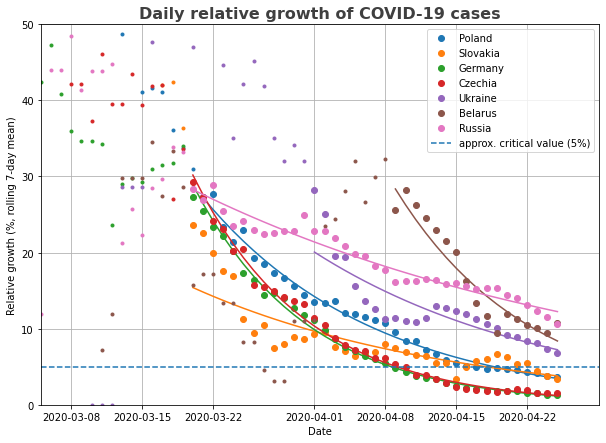

In [4]:
fig = plt.figure(figsize=(10,7))

span = 7
rel = relgr.rolling(span).mean()

for n, c in enumerate(selcnt):
    m = ~ (np.isnan(rel[c].values) | np.isinf(rel[c].values))
    t = np.arange(m.size)
    t = rel.index.to_pydatetime()
    for s, v in zip(t[m][::-1], rel[c].values[m][::-1]):
        if v>0.3 :
            break
    mm = m & (t > s)
    x = arange(rel.index.size)
    fit = polyfit(x[mm], log(rel[c].values[mm]), 1)
    p = plt.plot(rel.index[m], 100*rel[c].values[m], '.')[0]
    plt.plot(rel.index[mm], 100*rel[c].values[mm], 'o', label=c, color=p.get_color())
    plt.plot(rel.index[mm], 100 * exp(polyval(fit, x[mm])), color=p.get_color())

plt.axhline(5, ls='--', label='approx. critical value (5%)')
plt.ylim(0,50)
plt.xlim(pd.Timestamp('2020-03-5'),None)
plt.title('Daily relative growth of COVID-19 cases', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel(f'Relative growth (%, rolling {span}-day mean)')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.savefig('relative_growth.png');

## Trajectory 
This one is inspired by the excellent https://aatishb.com/covidtrends/ page

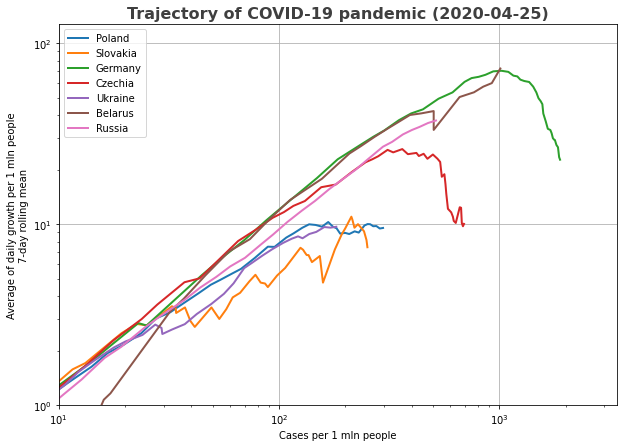

In [5]:
plt.figure(figsize=(10,7))
val = 10*confpc
span = 7
gr = val.diff().rolling(span).mean()

for n, c in enumerate(selcnt):
    m = ~ gr[c].isnull()
    plt.loglog(val[c][m].values, gr[c][m].values, '-', label=c, lw=2)

plt.xlim(10,None)
plt.ylim(1,None)
plt.title(f'Trajectory of COVID-19 pandemic ({str(val.index[-1]).split()[0]})', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel('Average of daily growth per 1 mln people\n'+
           f'{span}-day rolling mean')
plt.xlabel('Cases per 1 mln people')
plt.legend()
plt.grid()
plt.savefig('trajectory.png');

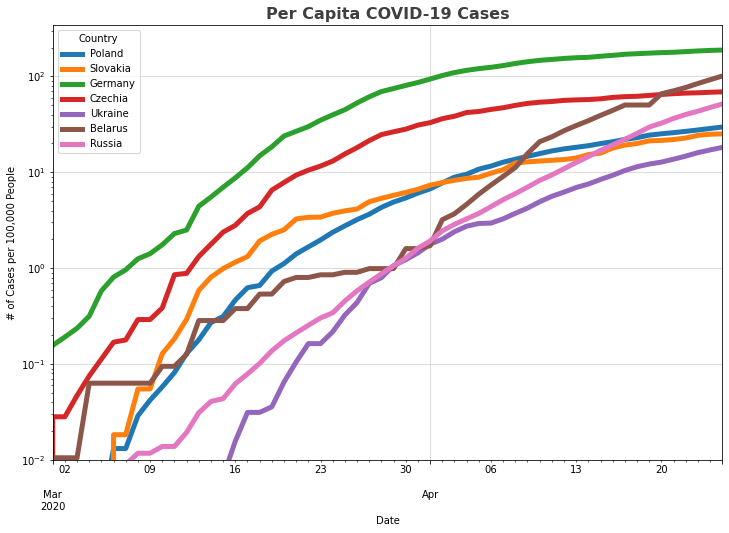

In [6]:
percapitaplot = confpc[selcnt].plot(figsize=(12,8), linewidth=5, logy=LOGY)
percapitaplot.grid(color='#d4d4d4')
percapitaplot.set_xlabel('Date')
percapitaplot.set_ylabel('# of Cases per 100,000 People')
percapitaplot.set_xlim(pd.Timestamp('2020-03-1'),None)
percapitaplot.set_ylim(1e-2, None)
percapitaplot.set_title("Per Capita COVID-19 Cases", 
                        fontsize = 16, weight = 'bold', alpha = .75);

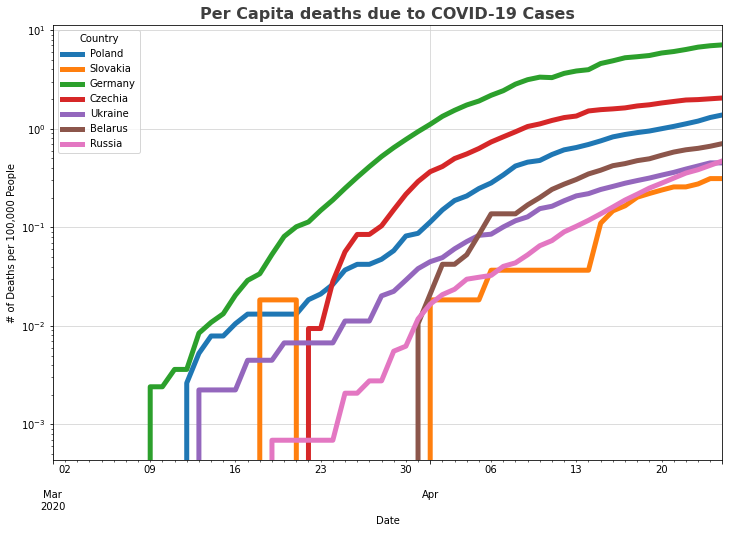

In [7]:
vplot = victpc[selcnt].plot(figsize=(12,8), linewidth=5, logy=LOGY)
vplot.grid(color='#d4d4d4')
vplot.set_xlabel('Date')
vplot.set_ylabel('# of Deaths per 100,000 People')
vplot.set_xlim(pd.Timestamp('2020-03-1'),None)
vplot.set_title("Per Capita deaths due to COVID-19 Cases", fontsize = 16, weight = 'bold', alpha = .75);

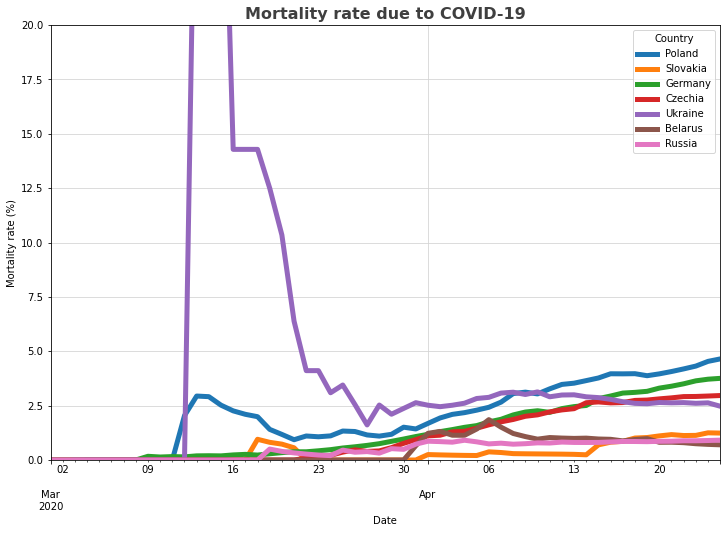

In [8]:
mortplt = (100*vict[selcnt]/conf[selcnt]).plot(figsize=(12,8), linewidth=5, logy=False)
mortplt.grid(color='#d4d4d4')
mortplt.set_xlim(pd.Timestamp('2020-03-1'),None)
mortplt.set_ylim(0, 20)
mortplt.set_xlabel('Date')
mortplt.set_ylabel('Mortality rate (%)')
mortplt.set_title('Mortality rate due to COVID-19', fontsize = 16, weight = 'bold', alpha = .75);

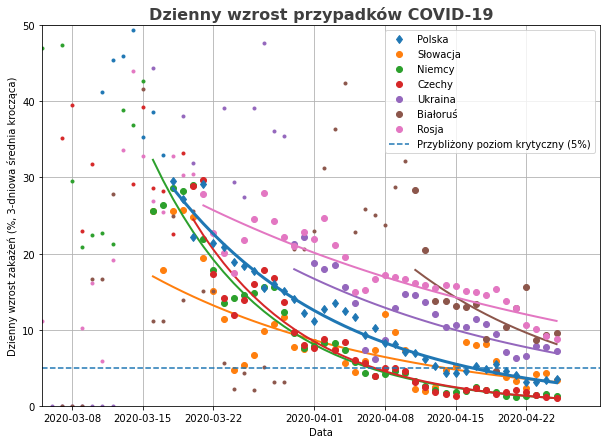

In [9]:
fig = plt.figure(figsize=(10,7))

def plleg(c):
    pl = {
        'Poland':'Polska', 
        'Slovakia': 'Słowacja', 
        'Germany': 'Niemcy',
        'Czechia': 'Czechy',
        'Ukraine': 'Ukraina', 
        'Belarus': 'Białoruś', 
        'Russia': 'Rosja'
    }
    if c in pl:
        return pl[c]
    else :
        return c

span = 3
rel = relgr.rolling(span).mean()
    
for n, c in enumerate(selcnt):
    m = ~ (np.isnan(rel[c].values) | np.isinf(rel[c].values))
    t = np.arange(m.size)
    t = rel.index.to_pydatetime()
    for s, v in zip(t[m][::-1], rel[c].values[m][::-1]):
        if v>0.3 :
            break
    mm = m & (t > s)
    x = arange(rel.index.size)
    fit = polyfit(x[mm], log(rel[c].values[mm]), 1)
    p = plt.plot(rel.index[m], 100*rel[c].values[m], '.')[0]
    plt.plot(rel.index[mm], 100*rel[c].values[mm], 
             'd' if c=='Poland' else 'o', 
             color=p.get_color(), label=plleg(c),
             zorder = 3 if c=='Poland' else 2,
            )
    plt.plot(rel.index[mm], 100 * exp(polyval(fit, x[mm])),
             color=p.get_color(),
             lw=3 if c=='Poland' else 2,
             zorder = 3 if c=='Poland' else 2)

plt.axhline(5, ls='--', label='Przybliżony poziom krytyczny (5%)')
plt.ylim(0,50)
plt.xlim(pd.Timestamp('2020-03-5'),None)
plt.title('Dzienny wzrost przypadków COVID-19', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel(f'Dzienny wzrost zakażeń (%, {span}-dniowa średnia krocząca)')
plt.xlabel('Data')
plt.grid()
plt.legend()
plt.savefig('wzrosty_dzienne.png');

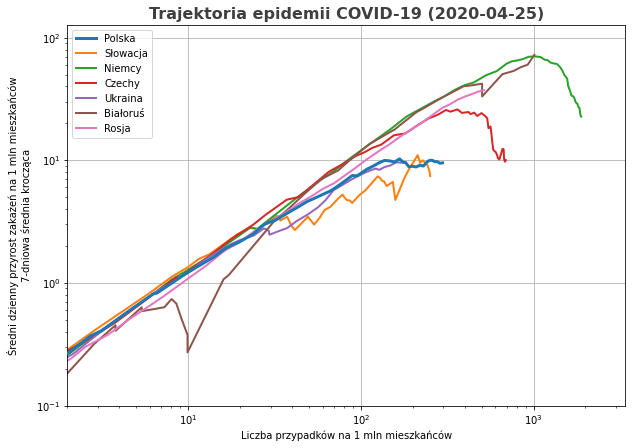

In [10]:
plt.figure(figsize=(10,7))
val = 10*confpc
span = 7
gr = val.diff().rolling(span).mean()

for n, c in enumerate(selcnt):
    m = ~ gr[c].isnull()
    plt.loglog(val[c][m].values, gr[c][m].values, 
               '-', lw=3 if c=='Poland' else 2, label=plleg(c),
               zorder = 3 if c=='Poland' else 2)

#plt.axhline(5, ls='--', label='Przybliżony poziom krytyczny (5%)')
plt.xlim(2,None)
plt.ylim(0.1,None)
plt.title(f'Trajektoria epidemii COVID-19 ({str(val.index[-1]).split()[0]})', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel('Średni dzienny przyrost zakażeń na 1 mln mieszkańców\n'+
           f'{span}-dniowa średnia krocząca')
plt.xlabel('Liczba przypadków na 1 mln mieszkańców')
plt.legend()
plt.grid()
plt.savefig('trajektoria_covid.png');

In [11]:
conf[-3:]

Country,Belarus,Czechia,Germany,Poland,Russia,Slovakia,Ukraine
Date,,,,,,,
2020-04-23,8022,7187,153129,10511,62773,1325,7170
2020-04-24,8773,7273,154999,10892,68622,1360,7647
2020-04-25,9590,7352,156513,11273,74588,1373,8125
